In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator

# Part 1: Model Complexity and Model Selection

## QUESTION 1: KNN Regressor

In this section, I will implement a custom KNN regressor as requested in question 1. Then, I'll test it by loading the diabetes dataset, performing a 70/30 train/test split, fitting the model, and reporting the training and test errors for a chosen $K$.

In [17]:
class KnnRegressor(BaseEstimator):

    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X_test):
        y_pred = []
        for x_test in X_test:
            # Calculate distances to all training points
            distances = np.sqrt(np.sum((self.X_train - x_test)**2, axis=1))

            # Get indices of k nearest neighbors and get the index of original array after ascending sort and take n_neighbors
            nearest_neighbors_indices = np.argsort(distances)[:self.n_neighbors]
            
            # Get the labels of the k nearest neighbors
            nearest_neighbors_labels = self.y_train[nearest_neighbors_indices]

            # Predict the label as the mean of the neighbors' labels
            y_pred.append(np.mean(nearest_neighbors_labels))

        return np.array(y_pred)


In [18]:
# Calculates the sum of squared errors
def sum_of_squared_errors(y, y_hat):
    return np.sum((y - y_hat) ** 2)


### Loading dataset and apply the test

In [19]:
from sklearn.datasets import load_diabetes

diabetes_data = load_diabetes()

# Explore data's features and shape
diabetes_data.feature_names, diabetes_data.data.shape

(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], (442, 10))

In [22]:
# Load the diabetes dataset
diabetes_data = load_diabetes()
X = diabetes_data.data
y = diabetes_data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## The effect of the hyper-parameter k

Applu code trains a K-Nearest Neighbors (KNN) regressor for different values of $K$ (from 1 to 30) and computes the **sum of squared errors (SSE)** for both the training and test datasets. The results are stored in two lists, **sum_of_squared_errors_train** and **sum_of_squared_errors_test** that track the SSE for each $K$.

In [23]:
sum_of_squared_errors_train = []
sum_of_squared_errors_test = []
max_k = 30
for k in range(1, max_k+1):
    knn = KnnRegressor(k).fit(X_train, y_train)
    sum_of_squared_errors_train.append(sum_of_squared_errors(y_train, knn.predict(X_train)))
    sum_of_squared_errors_test.append(sum_of_squared_errors(y_test, knn.predict(X_test)))

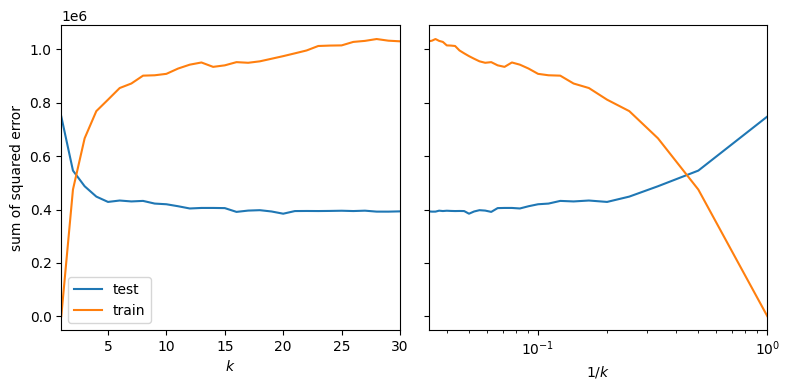

In [24]:
_, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, sharey=True)
ks = np.arange(1, max_k+1)
axs[0].plot(ks, sum_of_squared_errors_test, label='test')
axs[0].plot(ks, sum_of_squared_errors_train, label='train')
axs[0].margins(x=0)
axs[0].set_ylabel('Sum of squared error')
axs[0].set_xlabel('$k$')
axs[0].legend()
axs[1].plot(1/ks, sum_of_squared_errors_test)
axs[1].plot(1/ks, sum_of_squared_errors_train)
axs[1].margins(x=0)
axs[1].set_xlabel('$1/k$')
axs[1].set_xscale('log')
plt.show()

# Report of Training and Test Errors:

## Left plot:
- **Training Error (Orange Line):** As $K$ increases from around 1 to 30, the training error gradually rises. For small $K$ values (smaller than 5), the model fits the training data closely, leading to lower error. However, as $K$ increases (larger than 5), the error on the training data rises, indicating that the model becomes less capable of fitting the training data, likely due to **underfitting**.

- **Test Error (Blue Line):** The test error decreases initially as $K$ increases, indicating that the model is generalizing better with a slightly larger neighborhood of neighbors (optimal $K$). However, as $K$ continues to increase beyond a certain point, the model starts **underfitting**, and the test error increases or stabilizes.

## Right plot (1/k scale):
This plot shows the same data in terms of 1 \ $k$ , which presents an inverse relationship.
- **Training Error** increases sharply as 1 \ $k$ becomes larger, while the **Test Error** decreases at first and then starts to rise as 1 \ $k$ approaches zero, which correlates with larger $K$ values.

## Conclusion:
- The training error is lowest for small $K$ values and increases with larger $K$ values, indicating that higher $K$ values result in underfitting.
- The test error is minimized around \( $K$ = 3 \) and \( $K$ = 5 \), which seems to provide the best generalization to the test data, while very small or very large $K$ values perform worse in terms of test error.

This shows the trade-off between overfitting and underfitting as $K$ varies in a K-Nearest Neighbors model or similar scenario.


## QUESTION 2

In this section, I implemented LFold as required in question 2.1, then applied L-fold cross-validation for various K values in 2.2 and reported the results. Finally, in 2.3, I plotted the mean training and test performance against the different K values.

### QUESTION 2.1

In [25]:
class LFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        """
        Custom implementation of an L-Fold cross-validator.
        
        Parameters:
        - n_splits: Number of folds (default is 5).
        - shuffle: If True, the data is shuffled before splitting (default is False).
        - random_state: Seed for random number generator for reproducibility (default is None).
        """
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
    
    def get_n_splits(self, X=None, y=None, groups=None):
        """
        Return the number of splits (folds).
        """
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        """
        Generate indices to split data into training and test sets.
        
        Parameters:
        - X: Data to split.
        - y: (Optional) target values (not used here).
        - groups: (Optional) group labels for the samples (not used here).
        
        Returns:
        - A generator yielding training and testing indices for each fold.
        """
        n_samples = len(X)
        indices = np.arange(n_samples)
        
        # Shuffle the indices if shuffle is True
        if self.shuffle:
            rng = np.random.RandomState(self.random_state)
            rng.shuffle(indices)
        
        # Determine the sizes of each fold
        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
        fold_sizes[:n_samples % self.n_splits] += 1
        
        current = 0
        for fold_size in fold_sizes:
            # Create test indices for the current fold
            test_indices = indices[current:current + fold_size]
            
            # Create train indices by excluding test indices
            train_indices = np.concatenate([indices[:current], indices[current + fold_size:]])
            
            # Yield the train and test indices for the current fold
            yield train_indices, test_indices
            
            # Update current index for the next fold
            current += fold_size


### QUESTION 2.2


In [28]:
# Initialize KFold with 5 splits
kf = LFold(n_splits=5, shuffle=True, random_state=0)

# Function to perform L-fold cross-validation for a given K
def perform_cross_validation(K, X, y, kf):
    train_mse_scores = []
    test_mse_scores = []
    
    # Perform L-fold cross-validation
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Initialize KNN model with the given K
        model = KNeighborsRegressor(n_neighbors=K)
        
        # Fit the model on the training data
        model.fit(X_train, y_train)
        
        # Predict and calculate MSE for both train and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate MSE for the training and test predictions
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        
        # Append MSE scores for each fold
        train_mse_scores.append(train_mse)
        test_mse_scores.append(test_mse)
    
    # Compute the mean and standard deviation of MSE for train and test sets
    train_mse_mean = np.mean(train_mse_scores)
    train_mse_std = np.std(train_mse_scores)
    
    test_mse_mean = np.mean(test_mse_scores)
    test_mse_std = np.std(test_mse_scores)
    
    return train_mse_mean, train_mse_std, test_mse_mean, test_mse_std

# Initialize a dictionary to store the results for each K
results = {}

# Test K values from 1 to 30
for K in range(1, 31):
    # Perform cross-validation for each K and store the results
    train_mse_mean, train_mse_std, test_mse_mean, test_mse_std = perform_cross_validation(K, diabetes_data.data, diabetes_data.target, kf)
    
    # Store the mean and standard deviation of MSE for both train and test sets
    results[K] = {
        "train_mse_mean": train_mse_mean,
        "train_mse_std": train_mse_std,
        "test_mse_mean": test_mse_mean,
        "test_mse_std": test_mse_std,
    }

Best K: 16
Best Test MSE Mean: 3169.294757186063
Best Test MSE Std: 180.4608746226449


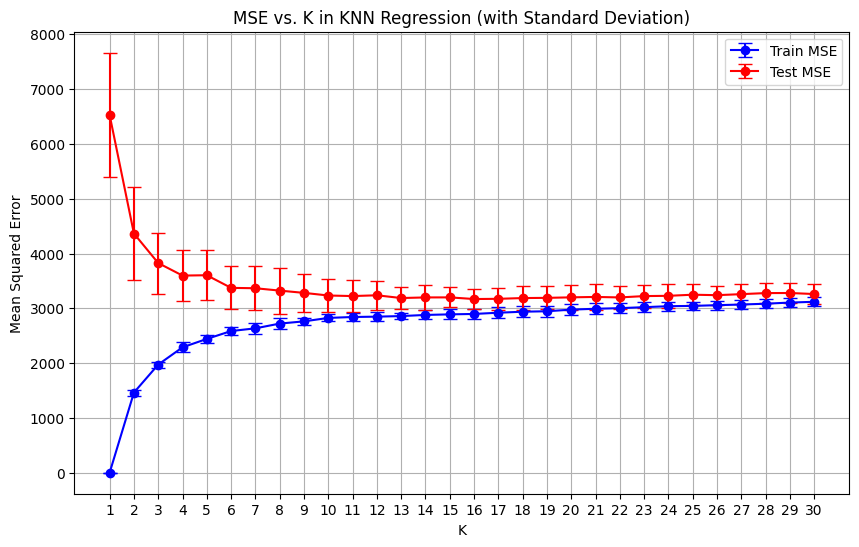

Best K: 16
Best Test MSE Mean: 3169.294757186063
Best Test MSE Std: 180.4608746226449


In [31]:
# Function to plot MSE vs. K
def plot_mse_vs_k_with_std(results):
    K_values = list(results.keys())
    train_mse_means = [results[K]['train_mse_mean'] for K in K_values]
    test_mse_means = [results[K]['test_mse_mean'] for K in K_values]
    train_mse_stds = [results[K]['train_mse_std'] for K in K_values]
    test_mse_stds = [results[K]['test_mse_std'] for K in K_values]
    
    plt.figure(figsize=(10, 6))
    
    # Plot train MSE with standard deviation
    plt.errorbar(K_values, train_mse_means, yerr=train_mse_stds, label='Train MSE', fmt='-o', color='blue', capsize=5)
    
    # Plot test MSE with standard deviation with 96%
    plt.errorbar(K_values, test_mse_means, yerr=test_mse_stds, label='Test MSE', fmt='-o', color='red', capsize=5)
    
    plt.title('MSE vs. K in KNN Regression (with Standard Deviation)')
    plt.xlabel('K')
    plt.ylabel('Mean Squared Error')
    plt.xticks(K_values)
    plt.grid(True)
    plt.legend()
    plt.show()


# Plot the MSE values
plot_mse_vs_k_with_std(results)

# Identify the K with the best test performance
best_K = min(results, key=lambda K: results[K]["test_mse_mean"])

# Print the best K and corresponding Test MSE
print(f"Best K: {best_K}")
print(f"Best Test MSE Mean: {results[best_K]['test_mse_mean']}")
print(f"Best Test MSE Std: {results[best_K]['test_mse_std']}")

# Key Results and Performance in KNN Regression
- **Best $K$**: 16
- **Best Test MSE Mean**: 3169.29
- **Best Test MSE Standard Deviation**: 180.46

## Best Performance:
**Optimal $K$**: Based on the graph, the test MSE decreases until \( K = 16 \), where the test MSE is minimized. Beyond this point, the test MSE either remains stable or starts increasing slightly, indicating that larger $K$ values may lead to underfitting.

**Test MSE**: At \( K = 16 \), the mean test MSE is approximately 3169.29 with a standard deviation of 180.46. This suggests that the model is performing well on unseen data at this $K$ value, and the variability of the test MSE across folds is relatively low.

## Observations:
- **For small $K$ values \( K = 1 \)**: The training MSE is very low, but the test MSE is quite high. This indicates overfitting, where the model fits the training data well but fails to generalize to new data.
  
- **For large $K$ values \( K > 20 \)**: The training MSE and test MSE both converge, but the test MSE starts increasing slightly after \( K = 16 \), indicating underfitting, where the model becomes too simple to capture the underlying patterns in the data.

## Summary:
In summary, K = 16 provides the best test performance, balancing bias and variance effectively in this KNN regression task.


### QUESTION 2.3

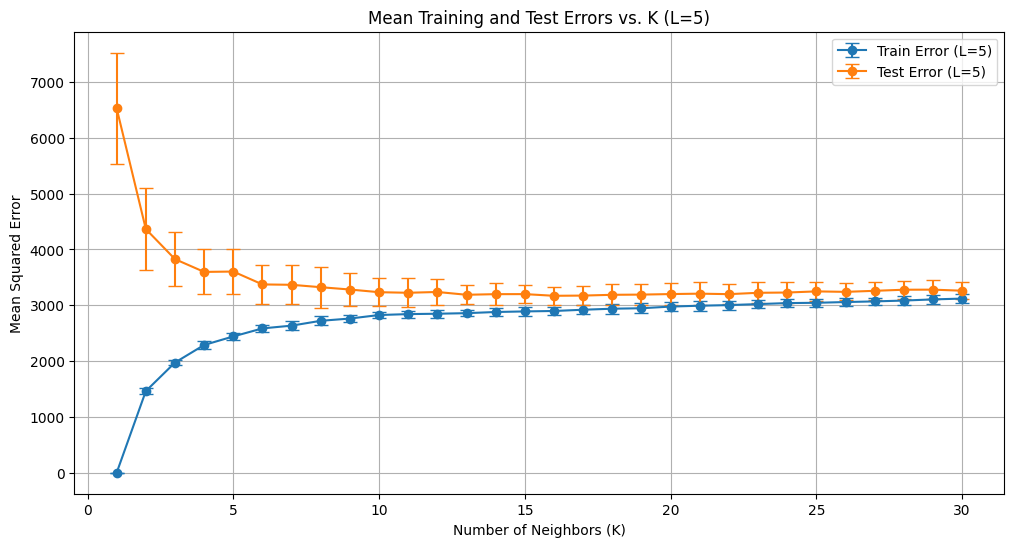

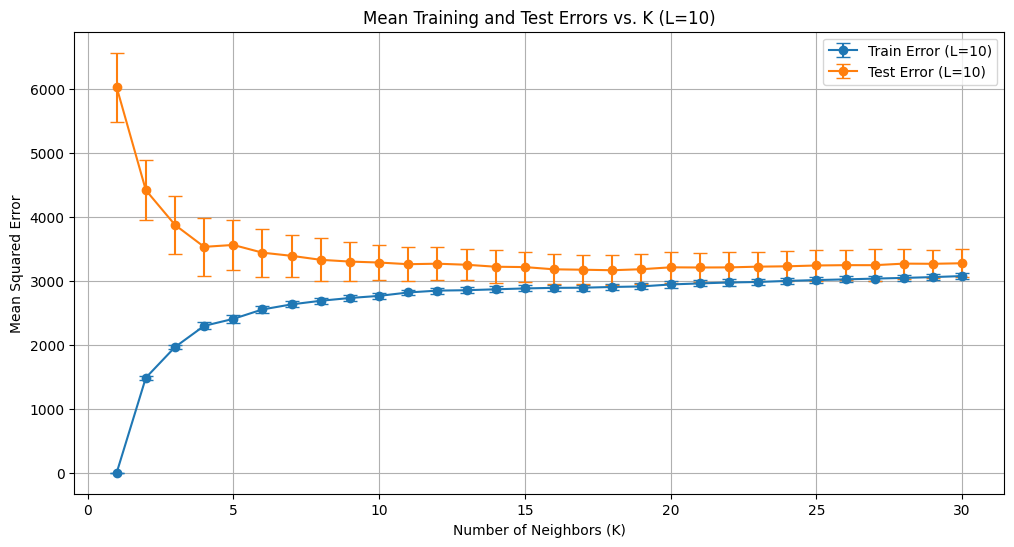

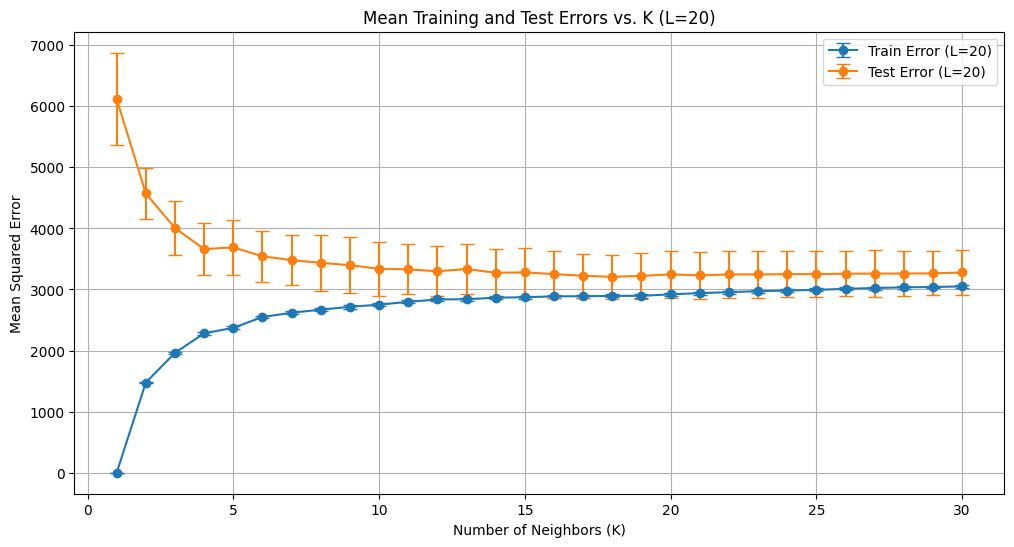

In [29]:
# Load the diabetes dataset
data = load_diabetes()
X, y = data.data, data.target

# Define range of K values to test
k_range = range(1, 31)

# Define different values of L to test
L_values = [5, 10, 20]

# Function to perform KNN with given K and L
def perform_knn(X, y, k_range, L):
    mean_train_errors = []
    mean_test_errors = []
    std_train_errors = []
    std_test_errors = []
    
    kf = LFold(n_splits=L, shuffle=True, random_state=0)
    for k in k_range:
        train_errors = []
        test_errors = []
        
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model = KNeighborsRegressor(n_neighbors=k)
            model.fit(X_train, y_train)
            
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Mean square error
            train_error = mean_squared_error(y_train, y_train_pred)
            test_error = mean_squared_error(y_test, y_test_pred)
            
            train_errors.append(train_error)
            test_errors.append(test_error)
        
        mean_train_error = np.mean(train_errors)
        mean_test_error = np.mean(test_errors)
        std_train_error = np.std(train_errors)
        std_test_error = np.std(test_errors)
        
        mean_train_errors.append(mean_train_error)
        mean_test_errors.append(mean_test_error)
        std_train_errors.append(std_train_error)
        std_test_errors.append(std_test_error)
    
    return mean_train_errors, mean_test_errors, std_train_errors, std_test_errors

# Plotting function
def plot_errors(k_range, mean_train_errors, mean_test_errors, std_train_errors, std_test_errors, L):
    plt.figure(figsize=(12, 6))
    plt.errorbar(k_range, mean_train_errors, yerr=[1.96 * np.array(std_train_errors) / np.sqrt(L)], label=f'Train Error (L={L})', capsize=5, fmt='-o')
    plt.errorbar(k_range, mean_test_errors, yerr=[1.96 * np.array(std_test_errors) / np.sqrt(L)], label=f'Test Error (L={L})', capsize=5, fmt='-o')
    plt.xlabel('Number of Neighbors (K)')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Mean Training and Test Errors vs. K (L={L})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Perform analysis for different L values
for L in L_values:
    mean_train_errors, mean_test_errors, std_train_errors, std_test_errors = perform_knn(X, y, k_range, L)
    plot_errors(k_range, mean_train_errors, mean_test_errors, std_train_errors, std_test_errors, L)

# Comment on the Effect of Parameters K and L
## 1. Effect of the Parameter $K$ (Number of Neighbors):

The parameter $K$, representing the number of neighbors in the K-Nearest Neighbors (KNN) model, significantly influences the model's performance. The behavior observed across different values of $K$ is crucial for understanding how the model interacts with the dataset.
### Overfitting Region $(K<5)$ :
- In regions where $K$ is very small (e.g., $K=1$ to $K=3$ ), the training error is typically very low, indicative of the model fitting very closely to the training data. However, the test error is significantly higher, suggesting overfitting due to low amount of neighbours. At these values, the model's complexity is high as it captures not only the underlying data patterns but also the noise, which hinders its ability to generalize well to new, unseen data.
### Underfitting Region ( $K>15$ ):
- Conversely, when $K$ is large (e.g., $K \geq 15$ ), both training and test errors tend to converge to a higher level compared to the optimal region. This behavior is indicative of underfitting (since it's averaging over a larger number of neighbors), where the model becomes too generalized, failing to capture essential data specifics, thus performing poorly on both training and test data.
### Optimal Region ( $K$ between 5 and 15 ):
- The behavior within this range often reflects a sharp decrease in test error up to a certain point, followed by stabilization or a slight increase. Typically, the minimal test error around $K=5$ suggests optimal model performance, balancing complexity and generalization, effectively managing the trade-off between bias and variance.
# 2. Effect of the Parameter $L$ in Cross-Validation:

The parameter $L$, indicating the number of folds in cross-validation, also affects the robustness of model evaluation.
- Smaller $L$ (e.g., $L=3$ ):Reducing $L$ leads to larger test sets and smaller training sets per fold, which can introduce greater variability in model performance estimation. This configuration might increase the cross-validation error's standard deviation due to less training data and more extensive testing in each fold.
- Larger $L$ (e.g., $L=10$ ):Increasing $L$ results in smaller test sets and larger training sets, enhancing the stability of performance estimates across different folds. This adjustment generally reduces the variability (smaller error bars) and provides more reliable insights into how the model might perform in general settings. However, this benefit comes at the cost of increased computational demand.

# Conclusion:
- Effect of $K$ : Low values of $K$ result in overfitting with low training error but high test error. High values lead to underfitting where the model is overly simplified. An optimal $K$ is often found in the middle range, where the model best manages to balance detailed learning and generalization (e.g., around $K=5$ ).
- Effect of $L$ : Variability in model evaluation can be managed by adjusting $L$. More folds mean more stable and reliable evaluations but at higher computational costs. An $L$ of 5 provides a reasonable balance for many practical applications. Adjusting $L$ can help in further understanding the model's performance and stability across different data splits.

## QUESTION 3

In this section, I will implement KNN regression and evaluate it using internal cross-validation (CV). The evaluation will be done with either a single train/test split or, preferably, with outer cross-validation, resulting in a nested cross-validation approach.

In [13]:
class KnnRegressorCV(BaseEstimator):
    def __init__(self, ks=list(range(1, 21)), cv=None):
        """
        KNN Regressor with Cross-Validation to select the best 'k' for the model.
        
        Parameters:
        - ks: List of k values to try during cross-validation (default is 1 to 20).
        - cv: Cross-validation strategy (an instance of an L-Fold or KFold cross-validator).
        """
        self.ks = ks  # List of k values to test
        self.cv = cv  # Cross-validation strategy
        self.k_ = None  # To store the best k after fitting
    
    def fit(self, X, y):
        """
        Fit the model by selecting the best k using cross-validation.
        
        Parameters:
        - X: Input features.
        - y: Target values.
        
        Returns:
        - self: Fitted estimator with the best k.
        """
        best_k = None
        best_score = float('inf')  # Start with a very high error score
        
        # Iterate over each k value in the provided list
        for k in self.ks:
            cv_scores = []
            
            # Perform cross-validation with the current k
            for train_index, val_index in self.cv.split(X):
                # Initialize KNN model with current k
                knn = KNeighborsRegressor(n_neighbors=k)
                knn.fit(X[train_index], y[train_index])  # Fit on the training fold
                
                # Predict on the validation fold and compute MSE
                predictions = knn.predict(X[val_index])
                mse = mean_squared_error(y[val_index], predictions)
                cv_scores.append(mse)
            
            # Calculate the mean MSE for the current k
            mean_cv_score = np.mean(cv_scores)
            
            # Update the best k if the current MSE is lower than the best found so far
            if mean_cv_score < best_score:
                best_score = mean_cv_score
                best_k = k
        
        # Store the best k found during cross-validation
        self.k_ = best_k
        
        # Finally, train the KNN regressor with the best k on the entire dataset
        self.best_knn_ = KNeighborsRegressor(n_neighbors=self.k_)
        self.best_knn_.fit(X, y)
        
        return self
    
    def predict(self, X):
        """
        Predict using the best KNN regressor after fitting.
        
        Parameters:
        - X: Input features.
        
        Returns:
        - Predictions for the input data.
        """
        return self.best_knn_.predict(X)


In [14]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score

# Load the diabetes dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

# Create an instance of the custom LFold
kf = LFold(n_splits=5, shuffle=True, random_state=42)

# Create an instance of KnnRegressorCV
knn_cv = KnnRegressorCV(ks=list(range(1, 21)), cv=kf)

# Perform a simple train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
knn_cv.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_cv.predict(X_test)

# Calculate the test MSE
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse}")
print(f"Best k chosen by internal CV: {knn_cv.k_}")


Test MSE: 3083.9003329171865
Best k chosen by internal CV: 18


## KNN Regressor with internal cross-validation vs outer test
In this analysis, the K-Nearest Neighbors (KNN) regressor with internal cross-validation selects K = 18, resulting in a mean MSE of 3084. However, the outer cross-validation identifies the best K = 16, with a slightly higher mean MSE of 3169. 
## Factors Affecting the Success of Internal CV:
1. **Data Distribution and Variability:** If the training data is highly representative of the test data (i.e., the folds are well-distributed), internal cross-validation is more likely to choose the best model.
2. **K Value Search Space:** A sufficiently broad range of K values must be explored to ensure the internal CV can identify the true best K.
3. **Model Complexity vs. Bias-Variance Trade-off:** A smaller K may overfit while a larger K may underfit. Internal CV aims to balance this trade-off, but if the variance in the data is high, it may struggle to consistently select the best model.
4. **Cross-Validation Setup:** The performance of internal CV depends on the robustness of the inner CV (number of splits, randomness in the shuffling). Larger splits and multiple folds generally provide more reliable results.

By comparing the optimal K selected during internal cross-validation with the test performance in outer cross-validation, we can evaluate the effectiveness of the internal procedure. If the MSE on the outer test set remains consistently low for the chosen K, then the internal cross-validation can be considered successful in selecting a well-performing model.